## Image Analysis and Threshold Selection

This section helps you visually evaluate and select an appropriate threshold for your image analysis.

### What's happening here:
- **Original Images**: Displays the original images you've provided.
- **Blue-to-Red Ratio Maps**: Visual representations show how much the blue channel dominates over the red channel in each image.
- **Threshold Visualization**: Highlights pixels that exceed your chosen threshold, making it easy to select the right threshold for your data.

### How to Activate:

1. **Set your image folder** (`image_folder`).
2. **Specify the number of images** you want to preview (`N_IMAGES_TO_PLOT`).
3. **Choose a starting threshold** (`suggested_threshold`, recommended is `1.1`).
4. Run the code cell below and review the results to adjust the threshold as needed.

This will ensure your analysis accurately reflects your specific dataset.


In [ ]:
%%capture
!pip install tifffile imagecodecs
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm
import imagecodecs

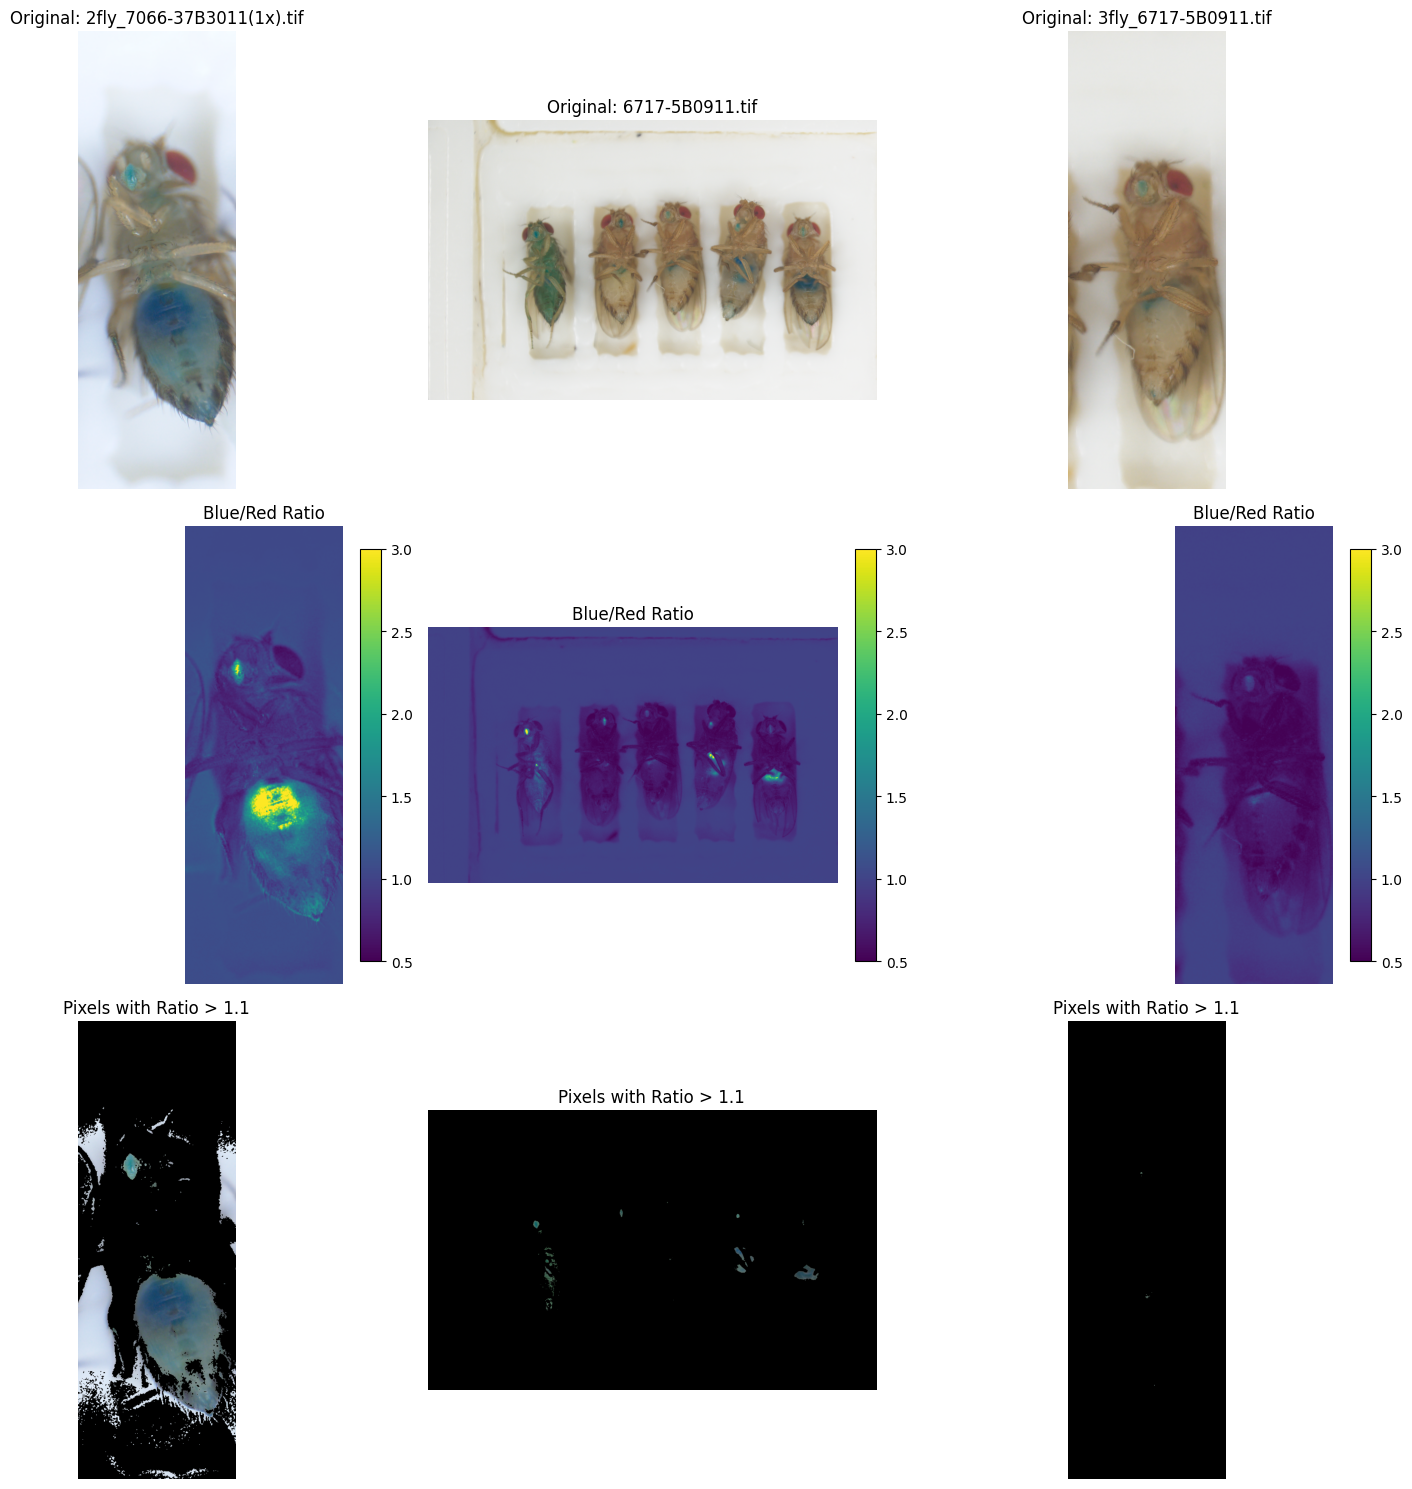

Review the visualizations above to confirm or adjust your threshold value (currently 1.1).


In [ ]:
# Number of images you want to test with:
N_IMAGES_TO_PLOT = 3

# Suggested starting threshold value (you can adjust after seeing results):
suggested_threshold = 1.1

# Directory containing your images:
image_folder = '/content/drive/MyDrive/SMF_test'

# --------------------------------------
# Step 1: Load images (no edits needed)
# --------------------------------------



# Load image file paths from the directory
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]

# Randomly select images for visualization
selected_files = random.sample(image_files, min(N_IMAGES_TO_PLOT, len(image_files)))

# Load and normalize images
images = []
for file_path in selected_files:
    img = tifffile.imread(file_path)
    if img.dtype != np.uint8:
        img = (img / img.max() * 255).astype(np.uint8)
    images.append((os.path.basename(file_path), img))

# --------------------------------------
# Step 2: Visualize images to choose threshold
# --------------------------------------

num_images = len(images)
fig, axes = plt.subplots(3, num_images, figsize=(5 * num_images, 15))

for idx, (name, img) in enumerate(images):
    # Original image
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'Original: {name}')
    axes[0, idx].axis('off')

    # Blue/Red ratio visualization
    blue = img[:, :, 2].astype(float)
    red = img[:, :, 0].astype(float)
    ratio = blue / (red + 1e-6)

    im = axes[1, idx].imshow(ratio, cmap='viridis', vmin=0.5, vmax=3)
    axes[1, idx].set_title('Blue/Red Ratio')
    axes[1, idx].axis('off')
    plt.colorbar(im, ax=axes[1, idx], fraction=0.046, pad=0.04)

    # Threshold visualization
    mask = ratio > suggested_threshold
    thresholded_img = np.zeros_like(img)
    thresholded_img[mask] = img[mask]
    axes[2, idx].imshow(thresholded_img)
    axes[2, idx].set_title(f'Pixels with Ratio > {suggested_threshold}')
    axes[2, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"Review the visualizations above to confirm or adjust your threshold value (currently {suggested_threshold}).")

## Running the Image Analysis

This part of the script automatically processes all images in your specified folder and generates:

- **Ratio Maps**: Visualizations of the Blue-to-Red color ratio for each image.
- **Filtered Pixel Images**: Images highlighting only pixels above the threshold value.
- **A CSV file** summarizing the results (number and percentage of pixels above the threshold per image).

### How to Activate:

1. **Set your paths clearly:**
   - `image_folder`: Folder where your original images are stored.
   - `output_folder`: Folder where you want your processed results saved.

2. **Set the threshold value** (`threshold_value`) based on the visual analysis you previously performed.

3. **Run the script** by executing the provided code cell.

### Results:

After running, you'll get:
- Processed images saved in the `ratio_maps` and `filtered_pixels` folders.
- A clear summary CSV file (`analysis_results.csv`) in your output folder.
- Information printed on the screen indicating how many images were successfully processed and if any were skipped due to errors.

This process simplifies your image analysis workflow, providing structured and insightful data.


In [ ]:
%%capture
!pip install tifffile imagecodecs
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm
import imagecodecs

In [ ]:
# ======================================
# Step 1: Define settings clearly
# --------------------------------------

# Path to the folder containing your images:
image_folder = '/content/drive/MyDrive/SMF_test' ### Change it to your path

# Path where you want to save the processed results:
output_folder = 'SMF_results' # Here the images of blue/red and filtered images folders will be located

# Threshold value for filtering pixels (default recommended is 1.1):
threshold_value = 1.1

# --------------------------------------
# Step 2: Run the processing (no edits needed below)
# --------------------------------------



# Function to create necessary folders
def create_folders(base_folder):
    ratio_maps_folder = os.path.join(base_folder, 'ratio_maps')
    filtered_pixels_folder = os.path.join(base_folder, 'filtered_pixels')

    os.makedirs(ratio_maps_folder, exist_ok=True)
    os.makedirs(filtered_pixels_folder, exist_ok=True)

    return ratio_maps_folder, filtered_pixels_folder

# Main image processing function
def analyze_images(input_folder, results_folder, threshold):
    ratio_maps_folder, filtered_pixels_folder = create_folders(results_folder)

    image_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]
    image_files = image_files[3:]  # Skip non-image files if needed

    results_data = []
    error_count = 0

    for image_file in tqdm(image_files, desc="Analyzing images"):
        try:
            img = tifffile.imread(image_file)
            filename = os.path.basename(image_file).split('.')[0]

            if img.dtype != np.uint8:
                img = (img / img.max() * 255).astype(np.uint8)

            blue = img[:, :, 2].astype(float)
            red = img[:, :, 0].astype(float)
            ratio = blue / (red + 1e-6)

            mask = ratio > threshold
            filtered_img = np.zeros_like(img)
            filtered_img[mask] = img[mask]

            pixel_count = np.sum(mask)
            total_pixels = img.shape[0] * img.shape[1]
            percentage_above_threshold = (pixel_count / total_pixels) * 100

            ratio_img = plt.cm.viridis(np.clip(ratio / 3, 0, 1))[:, :, :3]
            ratio_img = (ratio_img * 255).astype(np.uint8)

            cv2.imwrite(os.path.join(ratio_maps_folder, f'{filename}_ratio.png'), cv2.cvtColor(ratio_img, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(filtered_pixels_folder, f'{filename}_filtered.png'), cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR))

            results_data.append({
                'Image': filename,
                'Pixels-Above-Threshold': pixel_count,
                'Percentage-Above-Threshold': percentage_above_threshold,
                'Total-Pixels': total_pixels
            })

        except Exception as error:
            print(f"Skipped {image_file} due to error: {error}")
            error_count += 1

    df = pd.DataFrame(results_data)
    csv_path = os.path.join(results_folder, 'analysis_results.csv')
    df.to_csv(csv_path, index=False)

    total_images = len(image_files)
    print(f"\nProcessing complete.")
    print(f"Results saved to {csv_path}")
    print(f"Skipped {error_count} out of {total_images} images due to errors.")

    return df

# --------------------------------------
# Step 3: Execute the image analysis
# --------------------------------------

if __name__ == "__main__":
    analyze_images(image_folder, output_folder, threshold_value)


Analyzing images:  40%|████      | 6/15 [00:00<00:00, 28.03it/s]

Skipped /content/drive/MyDrive/SMF_test/3fly_6709-1B0911.tif due to error: <COMPRESSION.LZW: 5> requires the 'imagecodecs' package
Skipped /content/drive/MyDrive/SMF_test/4fly_6709-1B0911.tif due to error: <COMPRESSION.LZW: 5> requires the 'imagecodecs' package


Analyzing images: 100%|██████████| 15/15 [00:00<00:00, 20.40it/s]


Processing complete.
Results saved to SMF_results/analysis_results.csv
Skipped 2 out of 15 images due to errors.


## Draft

In [ ]:
# Specify the folder containing images
image_folder = '/content/drive/MyDrive/SMF_test' # Update with your folder path

# Load images from the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]

# filter out non-image files
image_files = image_files[3:]

images, valid_image_files = [], []
for file in image_files:
    try:
        img = tifffile.imread(file)
        images.append(img)
        valid_image_files.append(os.path.basename(file))
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")

# Normalize images for display
normalized_images = []
for img in images:
    if img.dtype != np.uint8:
        img_norm = (img / img.max() * 255).astype(np.uint8)
    else:
        img_norm = img.copy()
    normalized_images.append(img_norm)

# DataFrame to store results
data = []

# Plot setup
num_images = len(normalized_images)
fig, axes = plt.subplots(3, num_images, figsize=(4 * num_images, 12), constrained_layout=True)

for idx, image_display in enumerate(normalized_images):
    # Original image
    axes[0, idx].imshow(image_display)
    axes[0, idx].set_title(f'Original Image {idx + 1}')
    axes[0, idx].axis('off')

    # Calculate blue/red ratio safely
    blue_channel = image_display[:, :, 2].astype(float)
    red_channel = image_display[:, :, 0].astype(float)
    ratio = blue_channel / (red_channel + 1e-6)

    # Middle row: blue/red ratio visualization
    im = axes[1, idx].imshow(ratio, cmap='viridis', vmax=3)
    axes[1, idx].set_title('Blue/Red Ratio')
    axes[1, idx].axis('off')
    plt.colorbar(im, ax=axes[1, idx], fraction=0.046, pad=0.04)

    # Bottom row: Original image pixels where ratio > 1.1
    threshold = 1.1
    mask = ratio > threshold
    thresholded_img = np.zeros_like(image_display)
    thresholded_img[mask] = image_display[mask]
    pixel_count = np.count_nonzero(mask)
    axes[2, idx].imshow(thresholded_img)
    axes[2, idx].set_title(f'Pixels with Ratio > {threshold}\nPixel count: {pixel_count}')
    axes[2, idx].axis('off')

    # Store in DataFrame
    data.append({
        'Image': valid_image_files[idx],
        'Blue/Red-Ratio-Values': ratio.flatten(),
        'Pixels-Above-Threshold': pixel_count
    })

plt.show()

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
df

import seaborn as sns

# Sort the DataFrame by Pixels-Above-Threshold for better visualization
df_sorted = df.sort_values(by='Pixels-Above-Threshold')

# Create a figure with appropriate size
plt.figure(figsize=(12, 6))

# Create a bar plot with a nice color palette
ax = sns.barplot(
    x='Image',
    y='Pixels-Above-Threshold',
    data=df_sorted,
    palette='viridis'
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a title and labels
plt.title('Distribution of Pixels Above Threshold (Ratio > 1.1)', fontsize=16)
plt.xlabel('Image File', fontsize=12)
plt.ylabel('Number of Pixels', fontsize=12)

# Add values on top of the bars
for i, v in enumerate(df_sorted['Pixels-Above-Threshold']):
    ax.text(
        i,
        v + 0.05 * max(df_sorted['Pixels-Above-Threshold']),  # Position slightly above the bar
        f'{int(v)}',  # Format as integer
        ha='center',
        fontsize=10
    )

# Add a horizontal grid for better readability of values
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()